Dataset : [Dataset](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities)

Nama : Celvine

In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [70]:
if not os.path.isfile("dataset.zip"):
  print("Downloading dataset.....")
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_yTpOBaamUjELQiWxjBjCezQ_7mA63EA' -O dataset.zip

In [71]:
if not os.path.isfile("dataset.csv"):
  print("Prcess data.....")
  !unzip dataset.zip
  !mv city_temperature.csv dataset.csv

In [72]:
df = pd.read_csv("dataset.csv")
df.head()

<ipython-input-72-8eaf92ef3d7e>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [73]:
df.groupby('Country').size().to_frame()

,0
Country,
Albania,9266
Algeria,9266
Argentina,9266
Australia,46330
Austria,9266
...,...
Uzbekistan,9266
Venezuela,9265
Vietnam,9266


In [74]:
df = df[df['Country'] == 'United Arab Emirates']

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 1111584 to 1130115
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          18532 non-null  object 
 1   Country         18532 non-null  object 
 2   State           0 non-null      object 
 3   City            18532 non-null  object 
 4   Month           18532 non-null  int64  
 5   Day             18532 non-null  int64  
 6   Year            18532 non-null  int64  
 7   AvgTemperature  18532 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.3+ MB


In [76]:
df = df.drop(['Region','Country','City','State'], axis=1)

df['Date'] = df['Day'].astype(str) +"-"+ df['Month'].astype(str) +"-"+ df['Year'].astype(str)

df = df.drop(['Month','Day','Year'], axis=1)
df = pd.concat([df['Date'], df['AvgTemperature']], axis=1)

df.head()

,Date,AvgTemperature
1111584,1-1-1995,64.0
1111585,2-1-1995,67.1
1111586,3-1-1995,66.6
1111587,4-1-1995,65.0
1111588,5-1-1995,66.7


In [77]:
df.isnull().sum()

Date              0
AvgTemperature    0
dtype: int64

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 1111584 to 1130115
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            18532 non-null  object 
 1   AvgTemperature  18532 non-null  float64
dtypes: float64(1), object(1)
memory usage: 434.3+ KB


In [79]:
min_max_scaler = MinMaxScaler()

scaled_avg_temperature = min_max_scaler.fit_transform(df[['AvgTemperature']])

df['AvgTemperature'] = scaled_avg_temperature

df.head()

,Date,AvgTemperature
1111584,1-1-1995,0.789346
1111585,2-1-1995,0.804358
1111586,3-1-1995,0.801937
1111587,4-1-1995,0.794189
1111588,5-1-1995,0.802421


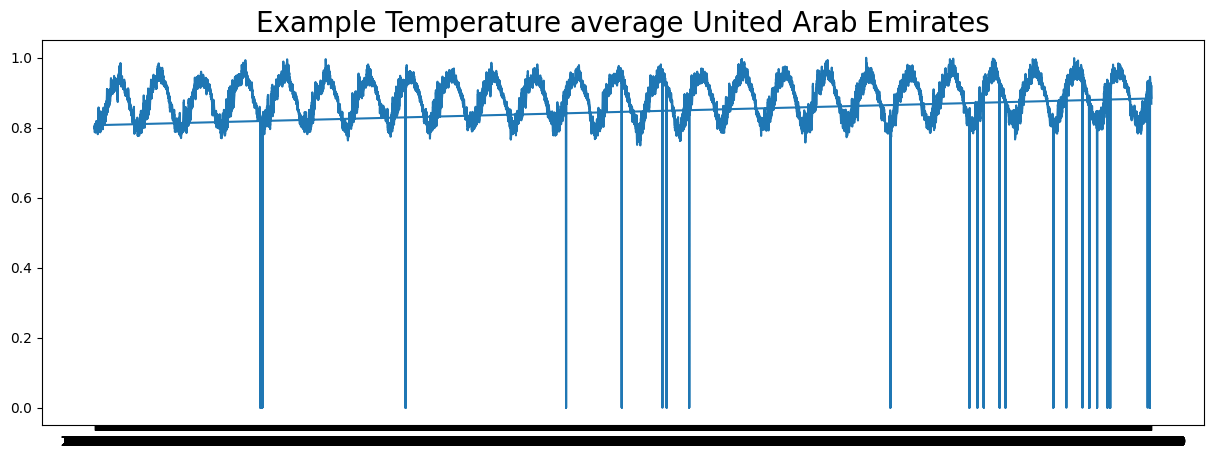

In [92]:
dates = df['Date'].values
avg_temperature = df['AvgTemperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates, avg_temperature)
plt.title('Example Temperature average United Arab Emirates', fontsize= 20);

In [81]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [82]:
X = df['Date']
y = df['AvgTemperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [83]:
print(f"Train : %s", len(y_train))
print(f"Test : %s", len(y_test))

Train : %s 14825
Test : %s 3707


In [84]:
train_set = windowed_dataset(y_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=100, shuffle_buffer=1000)

In [85]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, dropout=0.5),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [86]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [87]:
threshold_mae  = 10/100 * (df['AvgTemperature'].max() - df['AvgTemperature'].min())
threshold_mae

0.1

In [88]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("Model MEA and Validation MEA bellow 10%")
      self.model.stop_training = True

callbacks = myCallback()

In [89]:
history = model.fit(train_set, epochs = 100, validation_data=test_set, batch_size=16, callbacks=[callbacks])

Epoch 1/100
148/148 [==============================] - 10s 43ms/step - loss: 0.2722 - mae: 0.7262 - val_loss: 0.1534 - val_mae: 0.5515
Epoch 2/100
148/148 [==============================] - 4s 25ms/step - loss: 0.0975 - mae: 0.4242 - val_loss: 0.0373 - val_mae: 0.2678
Epoch 3/100
148/148 [==============================] - 4s 29ms/step - loss: 0.0272 - mae: 0.1929 - val_loss: 0.0073 - val_mae: 0.0999
Epoch 4/100
148/148 [==============================] - 4s 25ms/step - loss: 0.0137 - mae: 0.1212 - val_loss: 0.0036 - val_mae: 0.0528
Epoch 5/100
148/148 [==============================] - 4s 25ms/step - loss: 0.0119 - mae: 0.1157 - val_loss: 0.0032 - val_mae: 0.0465
Epoch 6/100
148/148 [==============================] - 6s 38ms/step - loss: 0.0113 - mae: 0.1135 - val_loss: 0.0032 - val_mae: 0.0458
Epoch 7/100
148/148 [==============================] - 4s 27ms/step - loss: 0.0106 - mae: 0.1105 - val_loss: 0.0032 - val_mae: 0.0459
Epoch 8/100
148/148 [==============================] - 4s 26m

In [90]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 60)          14880     
                                                                 
 lstm_19 (LSTM)              (None, 60)                29040     
                                                                 
 dense_28 (Dense)            (None, 16)                976       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 5)                 85        
                                                                 
 dense_30 (Dense)            (None, 1)                 6         
                                                                 
Total params: 44987 (175.73 KB)
Trainable params: 4498

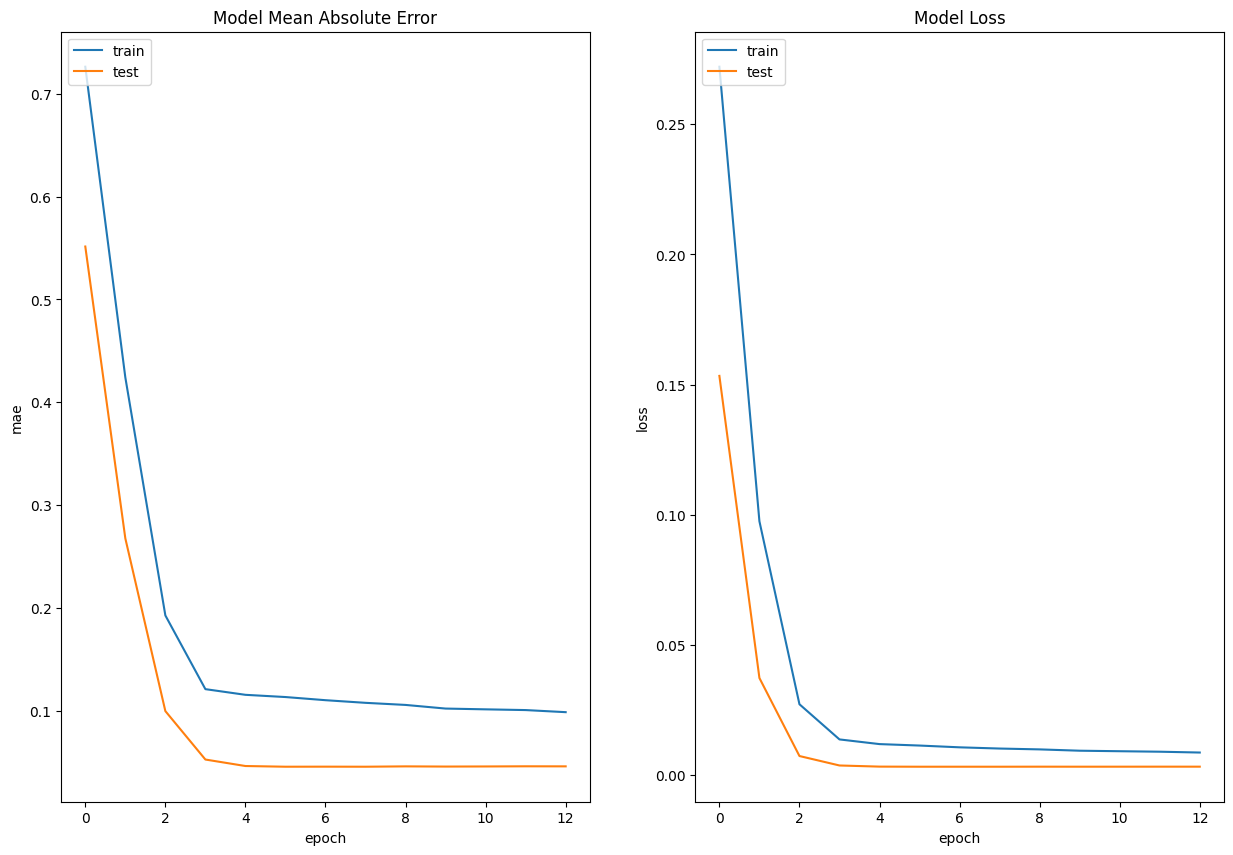

In [91]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')